In [1]:
import discretize
from SimPEG import (
    maps,
    utils,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    directives,
    inversion,
)
from SimPEG.electromagnetics.static import resistivity as DC, utils as DCutils
import numpy as np
import time
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver

%pylab inline


Populating the interactive namespace from numpy and matplotlib


15616


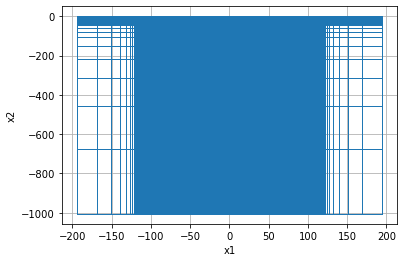

In [2]:
### mesh

# Cell sizes
csx, csz = 1.0, 0.5

# Number of core cells in each direction
ncx, ncz = 240, 45

# Number of padding cells to add in each direction
npadx = 8
npadz = 16

# Vectors of cell lengths in each direction with padding
hx = [(csx, npadx, -1.5), (csx, ncx), (csx, npadx, 1.5)]
hz = [(csz, npadz, -1.5), (csz, ncz)]

# Create mesh and center it
mesh = discretize.TensorMesh([hx, hz],x0="CN")

mesh.plotGrid()

print(mesh.nC)

In [3]:
### model

# background
rho_background = 10**1.5
mtrue = np.ones(mesh.nC) * rho_background

# conductive sphere
x0, z0, r0, rho0 = 0, -15, 7.0,10**-1
csph = (np.sqrt((mesh.gridCC[:, 0] - x0) ** 2.0
        + (mesh.gridCC[:, 1] - z0) ** 2.0)) < r0
mtrue[csph] = np.ones_like(mtrue[csph]) * rho0

# resistive layer
z1, rho1 = -2, 10**3
rlay = (mesh.gridCC[:, 1]) > z1
mtrue[rlay] = np.ones_like(mtrue[rlay]) * rho1

In [4]:
### survey & problem

IO = DC.IO()
xmin, xmax = -117.5,117.5
zmin, zmax = 0, 0
endl = np.array([[xmin, zmin], [xmax, zmax]])
survey = DCutils.generate_dcip_survey(endl, "dipole-dipole", dim=mesh.dim, a=5, b=5, n=10)
survey = IO.from_ambn_locations_to_survey(
    survey.locations_a,
    survey.locations_b,
    survey.locations_m,
    survey.locations_n,
    survey_type='dipole-dipole',
    data_dc_type="volt",
)

expmap = maps.ExpMap(mesh)
mapping = expmap 
problem = DC.Simulation2DCellCentered(
    mesh, survey=survey, rhoMap=mapping, solver=Solver, bc_type="Neumann"
)


/Users/lindseyjh/git/simpeg/simpeg/SimPEG/electromagnetics/static/resistivity/IODC.py:190: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


97.73537495443843
100.45898034521547


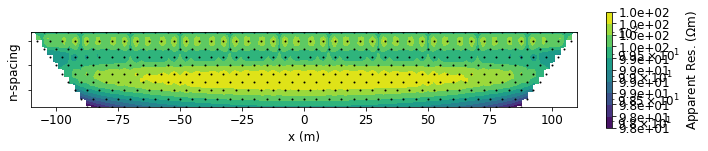

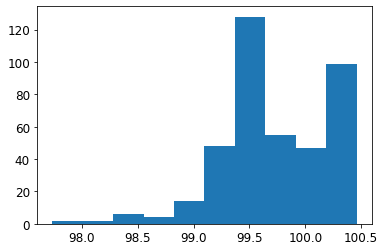

In [5]:
### test with homogeneous model

data_homo = problem.make_synthetic_data(log(ones(size(mtrue))*100), relative_error=0.0)

IO.plotPseudoSection(data=data_homo.dobs/IO.G, data_type="apparent_resistivity")

print(min(data_homo.dobs/IO.G))
print(max(data_homo.dobs/IO.G))

plt.figure()
plt.hist(data_homo.dobs/IO.G);

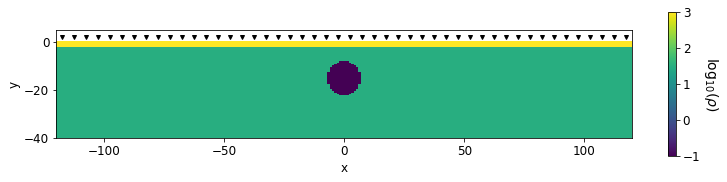

In [6]:
### plot model 

fig = plt.figure(figsize=(10,2))
ax = fig.add_axes([0,0,1,1],aspect='equal')   
dat = mesh.plotImage(log10(mtrue),ax=ax)
cbar = colorbar(dat[0])
cbar.set_label(r'log$_{10}$($\rho$)', rotation=270,labelpad=20,fontsize=14)
plt.ylim([-40,5])
plt.xlim([-120,120])
plt.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)

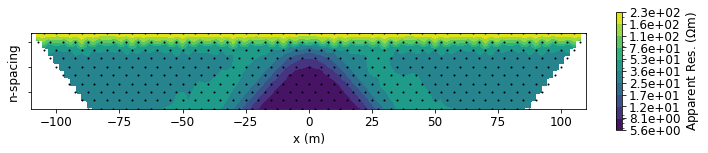

In [7]:
### plot data

data = problem.make_synthetic_data(log(mtrue), relative_error=0.03, add_noise=True)
IO.plotPseudoSection(data=data.dobs/IO.G, data_type="apparent_resistivity")

In [8]:
### inversion 

# reference model 
m0 = np.ones(mapping.nP)*np.log(mean(data.dobs/IO.G))

# data misfit
dmisfit = data_misfit.L2DataMisfit(simulation=problem, data=data)

# regularization mapping
regmap = maps.IdentityMap(nP=mesh.nC)

# inversion components
reg = regularization.Tikhonov(mesh, mapping=regmap)
opt = optimization.InexactGaussNewton(maxIter=10)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt) 
target = directives.TargetMisfit()
updateSensW = directives.UpdateSensitivityWeights()
update_Jacobi = directives.UpdatePreconditioner()    
start_time = time.time()
beta = directives.BetaEstimate_ByEig(beta0_ratio=1.)
betaSched = directives.BetaSchedule(coolingFactor=5., coolingRate=2)
inv = inversion.BaseInversion(invProb, directiveList=[updateSensW, beta, target, betaSched, update_Jacobi])

# run
mopt = inv.run(m0) 

jtj = np.sqrt(updateSensW.JtJdiag[0])
dpred = problem.dpred(mopt)
mpe = (mean(abs(data.dobs-dpred)/abs(data.dobs))*100)

print ('\r Time: {:.0f} mins'.format((time.time() - start_time)/60.))
 

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.63e+03  1.21e+06  0.00e+00  1.21e+06    7.77e+04      0              
   1  5.63e+03  1.20e+05  8.96e-01  1.25e+05    1.09e+04      0              
   2  1.13e+03  2.79e+04  1.25e+00  2.93e+04    1.57e+03      0   Skip BFGS  
   3  1.13e+03  1.75e+04  1.91e+00  1.97e+04    7.02e+02      0   Skip BFGS  
   4  2.25e+02  1.62e+04  1.96e+00  1.67e+04    2.60e+02      0              
   5  2.25e+02  1.29e+04  6.45e+00  1.43e+04    3.89e+02      0              
   6  4.50e+01  1.06e+04  7.73e+00  1.10e+04    3.07e+02  

Text(0.5, 1.0, 'M$_{est}$')

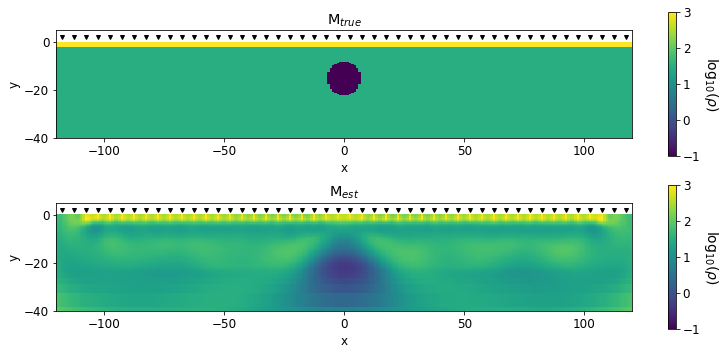

In [9]:
### plot estimated model

fig = plt.figure(figsize=(10,2))

ax = fig.add_axes([0,0,1,1],aspect='equal')   
dat = mesh.plotImage(log10(mtrue),ax=ax)
cbar = colorbar(dat[0])
cbar.set_label(r'log$_{10}$($\rho$)', rotation=270,labelpad=20,fontsize=14)
plt.ylim([-40,5])
plt.xlim([-120,120])
plt.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)
plt.title(r'M$_{true}$')

ax = fig.add_axes([0,-1.2,1,1],aspect='equal')   
dat = mesh.plotImage(log10(exp(mopt)),ax=ax,clim=[min(log10(mtrue)),max(log10(mtrue))])
cbar = colorbar(dat[0])
cbar.set_label(r'log$_{10}$($\rho$)', rotation=270,labelpad=20,fontsize=14)
plt.ylim([-40,5])
plt.xlim([-120,120])
plt.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)
plt.title(r'M$_{est}$')


### Building up the mappings

In [10]:
import scipy.sparse as sp
from SimPEG.maps import BaseParametric 

In [11]:
class ParametricLayer(BaseParametric):
    """
        Parametric Layer Space

        .. code:: python

            m = [
                val_background,
                val_layer,
                layer_z,
            ]

        **Required**

        :param discretize.base.BaseMesh mesh: SimPEG Mesh, 2D or 3D

        **Optional**

        :param float slopeFact: arctan slope factor - divided by the minimum h
                                spacing to give the slope of the arctan
                                functions
        :param float slope: slope of the arctan function
        :param numpy.ndarray indActive: bool vector with

    """

    def __init__(self, mesh, **kwargs):
        super(ParametricLayer, self).__init__(mesh, **kwargs)

    @property
    def nP(self):
        return 3

    @property
    def shape(self):
        if self.indActive is not None:
            return (sum(self.indActive), self.nP)
        return (self.mesh.nC, self.nP)

    def mDict(self, m):
        return {
            "val_background": m[0],
            "val_layer": m[1],
            "layer_z": m[2],
        }

    def _atanLayer(self, mDict):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        layer_z = mDict["layer_z"]
        return self._atanfct(z - layer_z, self.slope)
        
    def _transform(self, m):
        mDict = self.mDict(m)
        return mDict["val_background"] + (
            mDict["val_layer"] - mDict["val_background"]
        ) * self._atanLayer(mDict)


    def _deriv_val_background(self, mDict):
        return np.ones_like(self.x) - self._atanLayer(mDict)

    def _deriv_val_layer(self, mDict):
        return self._atanLayer(mDict)
    
    def _deriv_layer_z(self, mDict):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        layer_z = mDict["layer_z"]
        return (
            (mDict["val_layer"] - mDict["val_background"])*
            self._atanfctDeriv(z - layer_z, self.slope)
        )

    def deriv(self, m):
        mDict = self.mDict(m)
        return sp.csr_matrix(
            np.vstack(
                [
                    self._deriv_val_background(mDict),
                    self._deriv_val_layer(mDict),
                    self._deriv_layer_z(mDict),
                ]
            ).T
        )

In [12]:
parametric_layer = ParametricLayer(mesh)

(-120.0, 120.0)

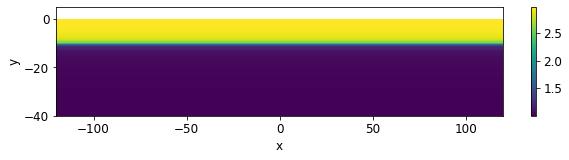

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plt.colorbar(mesh.plotImage(parametric_layer * np.r_[1, 3, -10], ax=ax)[0], ax=ax)
ax.set_ylim([-40,5])
ax.set_xlim([-120,120])

In [14]:
parametric_layer.test(np.r_[1, 3, -10])

Testing ParametricLayer(15616,3)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.266e+01     7.060e-01      nan
 1   1.00e-02    1.260e+00     6.887e-03      2.011
 2   1.00e-03    1.260e-01     6.854e-05      2.002
 3   1.00e-04    1.260e-02     6.850e-07      2.000
========================= PASS! =========================
Yay passed!



True

### construct the full mapping 

```
model = [np.log(rho_background), np.log(rho_layer), z_layer, np.log(rho_smooth)]
```

In [15]:
wires = maps.Wires(("parametric", 3), ("smooth", mesh.nC))
exp_map = maps.ExpMap(mesh)

In [16]:
sum_map = maps.SumMap([
    exp_map * parametric_layer * wires.parametric, 
    exp_map * wires.smooth
])

In [17]:
sigma_map = sum_map

In [18]:
# check with a simple example
eps = np.log(1e-8)
m_parametric = np.r_[np.log(1./rho_background), np.log(1./rho1), z1]
m_sphere = eps * np.ones(mesh.nC)
m_sphere[csph] = np.log(1./rho0)

m_true_parametric = np.hstack([m_parametric, m_sphere])

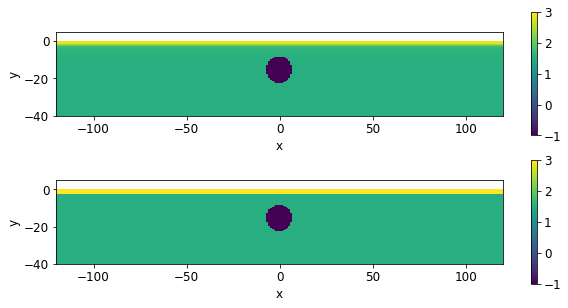

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

plt.colorbar(
    mesh.plotImage(np.log10(
        1./(sigma_map*m_true_parametric)
    ), clim = [-1, 3], ax=ax[0])[0], ax=ax[0]
)

plt.colorbar(
    mesh.plotImage(log10(mtrue), clim = [-1, 3], ax=ax[1])[0], ax=ax[1]
)


for a in ax: 
    a.set_ylim([-40,5])
    a.set_xlim([-120,120])
    a.set_aspect(1)

In [27]:
### inversion 

# reference model 
m0_parametric = np.r_[
    1./np.log(rho_background), 1./np.log(rho_background*100), -2
]
m0_smooth = eps*np.ones(mesh.nC)
m0 = np.hstack([m0_parametric, m0_smooth])

# simulation 
simulation_parametric = DC.Simulation2DCellCentered(
    mesh, survey=survey, sigmaMap=sigma_map, solver=Solver, bc_type="Neumann"
)

# data misfit
dmisfit = data_misfit.L2DataMisfit(simulation=simulation_parametric, data=data)

# regularization mapping
regmap = wires.smooth

# inversion components
reg = regularization.Tikhonov(mesh, mapping=regmap)
opt = optimization.InexactGaussNewton(maxIter=20)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt) 
target = directives.TargetMisfit()
updateSensW = directives.UpdateSensitivityWeights()
update_Jacobi = directives.UpdatePreconditioner()    
start_time = time.time()
beta = directives.BetaEstimate_ByEig(beta0_ratio=1.)
betaSched = directives.BetaSchedule(coolingFactor=5., coolingRate=2)
inv = inversion.BaseInversion(
    invProb, directiveList=[
#         updateSensW, 
        beta, target, betaSched, 
#         update_Jacobi
    ]
)

# run
mopt = inv.run(m0) 
 

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.01e-03  2.12e+05  0.00e+00  2.12e+05    1.16e+04      0              
   1  3.01e-03  1.62e+05  0.00e+00  1.62e+05    1.19e+05      2              
   2  6.01e-04  1.38e+05  0.00e+00  1.38e+05    1.49e+04      0              
   3  6.01e-04  1.19e+05  0.00e+00  1.19e+05    3.78e+04      3              
   4  1.20e-04  1.13e+05  0.00e+00  1.13e+05    7.49e+03      0              
   5  1.20e-04  1.12e+05  1.53e-03  1.12e+05    1.54e+04      4              
   6  2.41e-05  1.12e+05  1.53e-03  1.12e+05    1.13e+03  

In [28]:
dpred = simulation_parametric.dpred(mopt)
mpre_parametric = (mean(abs(data.dobs-dpred)/abs(data.dobs))*100)

print ('\r Time: {:.0f} mins'.format((time.time() - start_time)/60.))

 Time: 21 mins


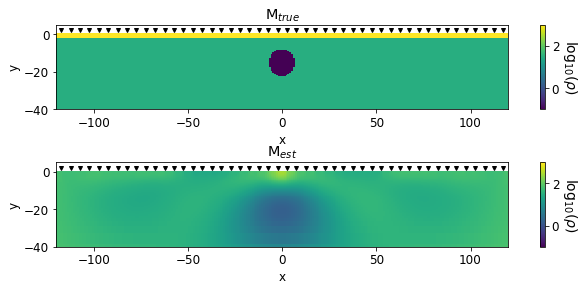

In [29]:
### plot estimated model

fig, ax = plt.subplots(2, 1, figsize=(10, 4))

dat = mesh.plotImage(log10(mtrue),ax=ax[0])
cbar = colorbar(dat[0], ax=ax[0])
cbar.set_label(r'log$_{10}$($\rho$)', rotation=270,labelpad=20,fontsize=14)
ax[0].set_title(r'M$_{true}$')

dat = mesh.plotImage(log10(1./(sigma_map * mopt)), ax=ax[1],clim=[min(log10(mtrue)),max(log10(mtrue))])
cbar = colorbar(dat[0], ax=ax[1])
cbar.set_label(r'log$_{10}$($\rho$)', rotation=270,labelpad=20,fontsize=14)
ax[1].set_title(r'M$_{est}$')

for a in ax:
    a.set_ylim([-40,5])
    a.set_xlim([-120,120])
    a.set_aspect(1)
    a.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)
plt.tight_layout()